# U-Net

In [2]:
!pip install rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import rarfile
import cv2
from pathlib import Path

from keras.utils import load_img, img_to_array, plot_model
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization,
                          Conv2D, Conv2DTranspose, concatenate)
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K
import keras
from IPython.display import clear_output

In [4]:
!wget 'https://drive.google.com/uc?export=download&id=1z0eATIZNn4vGt_ioS8N4mb1EZgEs40Sv' -O small_segment.rar

--2023-06-16 14:21:56--  https://drive.google.com/uc?export=download&id=1z0eATIZNn4vGt_ioS8N4mb1EZgEs40Sv
Resolving drive.google.com (drive.google.com)... 74.125.142.138, 74.125.142.100, 74.125.142.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rjtnbrbqjb9lapcpmk5n6160g6abpm3k/1686925275000/14904333240138417226/*/1z0eATIZNn4vGt_ioS8N4mb1EZgEs40Sv?e=download&uuid=0dd7103b-60fe-4ffc-aa5d-10f23bb46ad1 [following]
--2023-06-16 14:22:00--  https://doc-0o-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rjtnbrbqjb9lapcpmk5n6160g6abpm3k/1686925275000/14904333240138417226/*/1z0eATIZNn4vGt_ioS8N4mb1EZgEs40Sv?e=download&uuid=0dd7103b-60fe-4ffc-aa5d-10f23bb46ad1
Resolving doc-0o-c0-docs.googleusercontent.com (doc-0o-c0-docs.googleusercontent.com)... 74.125.195.132, 2607:

In [5]:
rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

labels/00_000200.png 19401
labels/00_000400.png 14502
labels/00_000600.png 19818
labels/00_000800.png 13554
labels/00_001000.png 14496
labels/00_001200.png 17371
labels/00_001400.png 12431
labels/00_001600.png 16390
labels/00_001800.png 16646
labels/00_002000.png 14844
labels/00_002200.png 14011
labels/00_002400.png 16921
labels/00_002600.png 15822
labels/00_002800.png 13681
labels/00_003000.png 13980
labels/00_003200.png 15122
labels/00_003400.png 13978
images/00_000200.png 791603
images/00_000400.png 816531
images/00_000600.png 862976
images/00_000800.png 836923
images/00_001000.png 829576
images/00_001200.png 822001
images/00_001400.png 858981
images/00_001600.png 797385
images/00_001800.png 850589
images/00_002000.png 818966
images/00_002200.png 641760
images/00_002400.png 714888
images/00_002600.png 774166
images/00_002800.png 890605
images/00_003000.png 837876
images/00_003200.png 755342
images/00_003400.png 695524
labels/ 0
images/ 0


In [6]:
path_imgs = '/content/images/'
path_masks = '/content/labels/'

imgs_paths = list(Path(path_imgs).iterdir())
masks_paths = list(Path(path_masks).iterdir())

In [7]:
images = []
masks = []
image_size = (200, 600)


for i_img, i_mask in zip(imgs_paths, masks_paths):
    images.append(load_img(i_img, target_size=image_size))
    masks.append(load_img(i_mask, target_size=image_size))

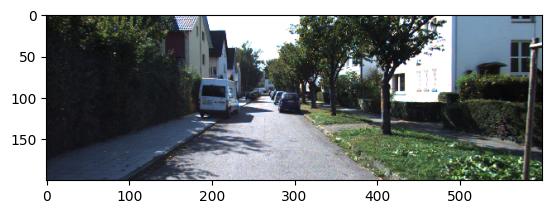

In [8]:
plt.imshow(images[1].convert('RGBA'))
plt.show()

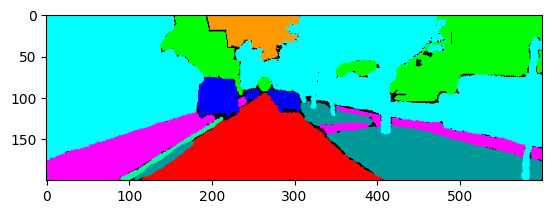

In [9]:
plt.imshow(masks[1].convert('RGBA'))
plt.show()

Создадим обучающую выборку

In [10]:
X = []

for img in images:
  x = img_to_array(img)
  X.append(x)

X = np.array(X)

In [11]:
print(X.shape)

(17, 200, 600, 3)


Построим цвет , воспринимаемого диапазона для сегментированной картинки - это результат разметки.

Color Coding:
Name (r,g,b) Class mapping

Car ( 0, 0,255) Object

Road (255, 0, 0) Road

Mark (255,255, 0) Road

Building ( 0,255, 0) Building

Sidewalk (255, 0,255) Road

Tree/Bush ( 0,255,255) Tree/Bush

Pole (255, 0,153) Sign/Pole

Sign (153, 0,255) Sign/Pole

Person ( 0,153,255) Object

Wall (153,255, 0) Building

Sky (255,153, 0) Sky

Curb ( 0,255,153) Road

Grass/Dirt ( 0,153,153) Grass/Dirt

Void ( 0, 0, 0) Void

Делаем конвертер в one-hot_encoding для выходных примеров

In [12]:
def Color2index(y):
    arr_col = [
        [0,0,255],
        [255,0,0],
        [255,255,0],
        [0,255,0],
        [255,0,255],
        [0,255,255],
        [255,0,153],
        [153,0,255],
        [0,153,255],
        [153,255,0],
        [255,153,0],
        [0,255,153],
        [0,153,153],
        [0,0,0]
    ]
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0])
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1
        i += 1

    return y_cat, y_ind#, i-1

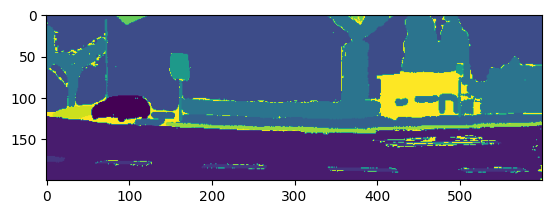

In [13]:
cat_yi, ind_yi = Color2index(img_to_array(masks[0]))
plt.imshow(ind_yi)
plt.show()

In [14]:
ind_yi

array([[ 4.,  4.,  4., ...,  4.,  4.,  4.],
       [ 4.,  4.,  4., ...,  4.,  4.,  4.],
       [ 4.,  4.,  4., ...,  4.,  4.,  4.],
       ...,
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2., 14., 14.],
       [ 2.,  2.,  2., ...,  2., 14., 14.]])

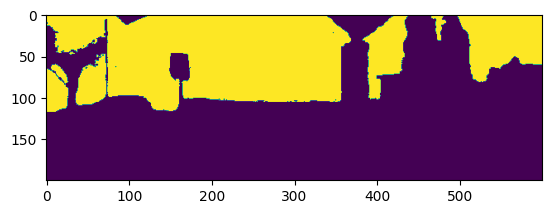

In [15]:
plt.imshow(cat_yi[..., 3])
plt.show()

In [16]:
cat_yi.shape

(200, 600, 14)

Сегментированную картинку в One hot encoding (разметка на 14 классов)

In [17]:
y = []

for mask in masks:
  y_cat, _ = Color2index(img_to_array(mask))
  y.append(y_cat)

y = np.array(y)

In [18]:
print(y.shape)

(17, 200, 600, 14)


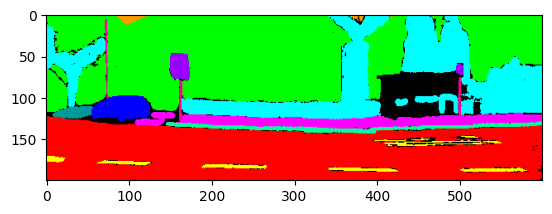

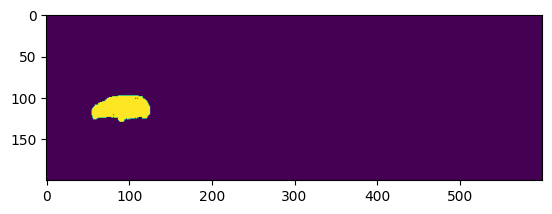

In [19]:
n = 0
plt.imshow(masks[n].convert('RGBA'))
plt.show()
img = y[n][..., 0]

plt.imshow(img)
plt.show()

Делим на train и test по числу N

In [20]:
N = 13
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

In [21]:
y_test.shape

(4, 200, 600, 14)

In [22]:
print(X_train.shape)
print(y_train.shape)

(13, 200, 600, 3)
(13, 200, 600, 14)


# Коэффициент DICE

In [23]:
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

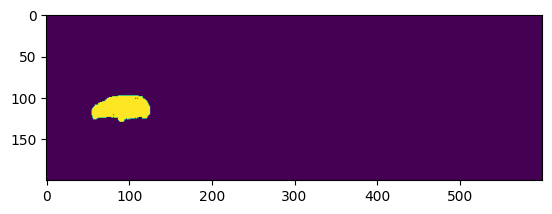

In [24]:
mask = y[0, ..., 0]
plt.imshow(mask);

Dice Coefficient of two same masks are 1.0


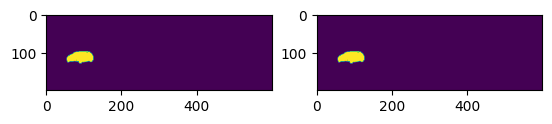

In [25]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(mask)
ax[1].imshow(mask)
print(f"Dice Coefficient of two same masks are {dice_coef(mask, mask)}")

Теперь сдвинем одну маску на 5 пикселей вниз

In [26]:
# We are just shifting the images towards the bottom to keep it simple
def return_shifted(mask, shift=5):
    nmask = np.zeros((mask.shape[0] + shift, mask.shape[1]))
    nmask[shift:, :] = mask
    nmask = nmask[:-shift, :]
    return nmask

Dice Coefficient of two same masks are 0.7903749630941836


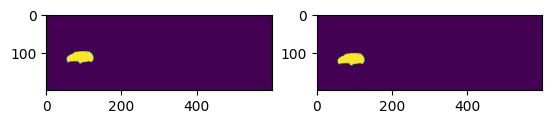

In [27]:
sh_mask = return_shifted(mask, shift=5)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(mask)
ax[1].imshow(sh_mask)
print(f"Dice Coefficient of two same masks are {dice_coef(mask, sh_mask)}")

На 50 пикселей в низ

Dice Coefficient of two same masks are 0.0002952465308532625


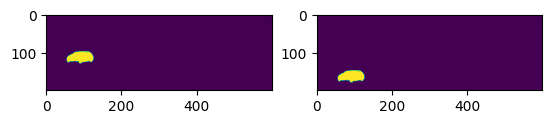

In [28]:
sh_mask = return_shifted(mask, shift=50)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(mask)
ax[1].imshow(sh_mask)
print(f"Dice Coefficient of two same masks are {dice_coef(mask, sh_mask)}")

# Создаём и обучаем U-Net

In [29]:
def Unet(num_classes=14, input_shape=(200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)


    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

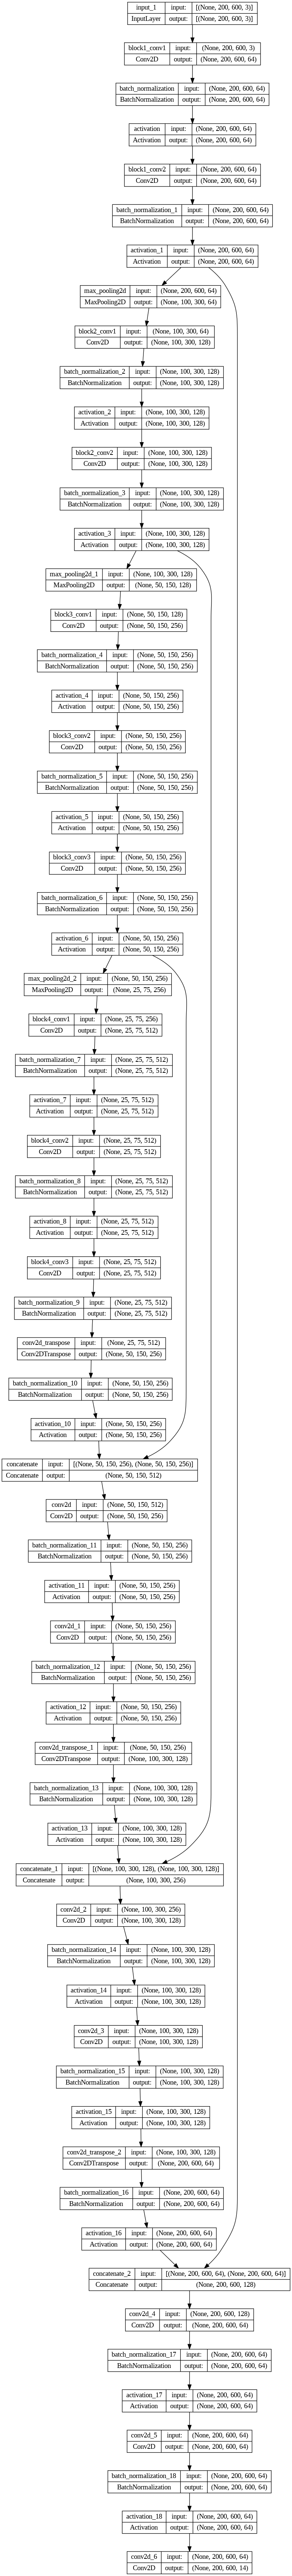

In [30]:
model_1 = Unet(14, (200, 600, 3))

plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [31]:
model_1.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 600, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 600, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

# Custom callback

In [32]:
sample_image = X_test[0]
sample_mask = y_test[0]

In [33]:
def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()

In [34]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience

    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

1/1 [==============================] - 12s 12s/step
(1, 200, 600)


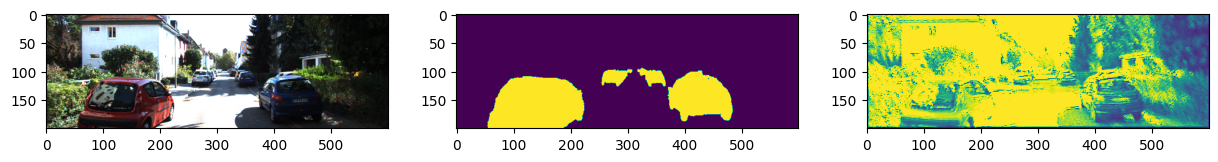

In [35]:
show_predictions(model_1)

1/1 [==============================] - 0s 121ms/step
(1, 200, 600)


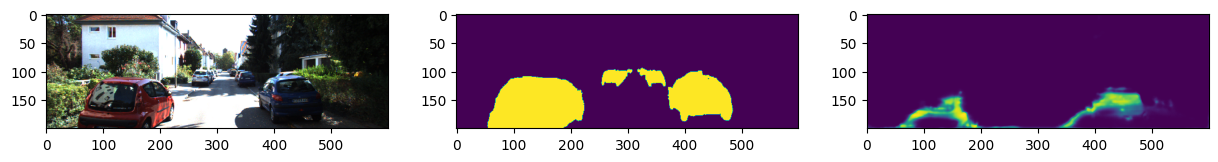


Sample Prediction after epoch 20
13/13 [==============================] - 3s 229ms/step - loss: 0.8699 - dice_coef: 0.5842 - val_loss: 3.2565 - val_dice_coef: 0.4795


In [36]:
history = model_1.fit(X_train, y_train,
                      epochs=20,
                      batch_size=1,
                      validation_data=(X_test, y_test),
                      callbacks=[DisplayCallback(patience=5)])

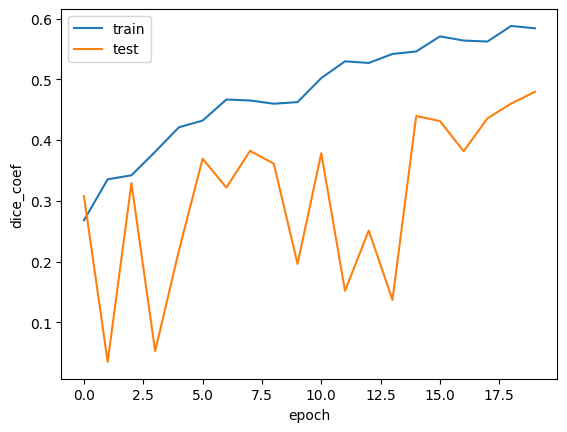

In [37]:
plt.plot(history.history['dice_coef'], label='train')
plt.plot(history.history['val_dice_coef'], label='test')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [38]:
pred = model_1.predict(X_test)
print(pred.shape)

1/1 [==============================] - 4s 4s/step
(4, 200, 600, 14)


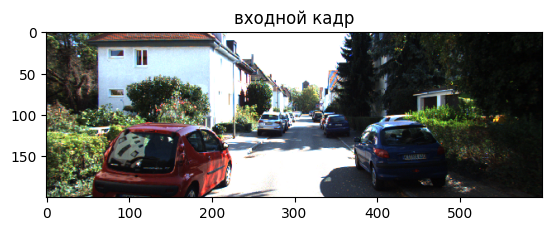

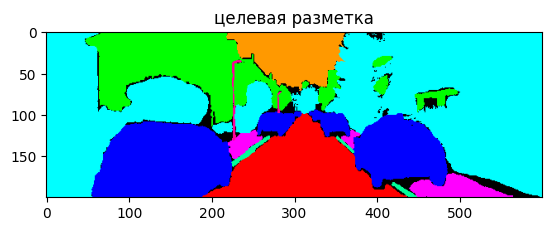

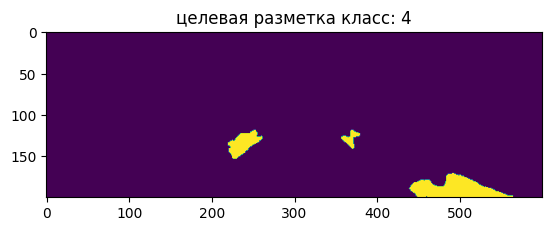

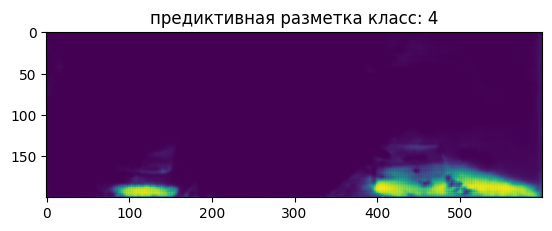

In [39]:
n = 0
class_ = 4
plt.imshow(images[N + n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(masks[N + n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_test[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()